In [1]:
!pip install lightgbm --upgrade

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 30.9 MB/s eta 0:00:00
  Attempting uninstall: lightgbm
    Found existing installation: lightgbm 4.2.0
    Uninstalling lightgbm-4.2.0:
      Successfully uninstalled lightgbm-4.2.0


In [2]:
import warnings
import gc

warnings.filterwarnings("ignore", category=FutureWarning, module="seaborn")

import pandas as pd
pd.set_option('display.float_format', lambda x: '%.3f' % x)

import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns

from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import matthews_corrcoef, confusion_matrix

from lightgbm import plot_importance
import lightgbm as lgb

from multiprocessing import cpu_count

import numpy as np

In [3]:
RAND = 42

In [4]:
print(f"Got {cpu_count()} cpus!")

Got 4 cpus!


# 1. Preparing data for LightGBM
We will use LightGBM native API as it allows for better flexibility with Callbacks and early stopping which are crucial for the development. In order to do that, we need to prepare our data and turn it into [Dataset](https://lightgbm.readthedocs.io/en/latest/pythonapi/lightgbm.Dataset.html#lightgbm.Dataset).

In [5]:
%%time

X_train = pd.read_parquet('/kaggle/input/ps4e8-data-eng/train.parquet', engine='pyarrow')
y_train = X_train.pop('class')
df_train = lgb.Dataset(X_train, params={'verbose': -1}, label=y_train)

X_test = pd.read_parquet('/kaggle/input/ps4e8-data-eng/test.parquet', engine='pyarrow')
y_test = X_test.pop('class')
df_test = lgb.Dataset(X_test, params={'verbose': -1}, label=y_test, reference=df_train)

X_val = pd.read_parquet('/kaggle/input/ps4e8-data-eng/val.parquet', engine='pyarrow')
assert 'class' not in X_val.columns

X_train

CPU times: user 1.6 s, sys: 2.24 s, total: 3.84 s
Wall time: 2 s


,cap-diameter,cap-shape,cap-surface,cap-color,does-bruise-or-bleed,gill-attachment,gill-spacing,gill-color,stem-height,stem-width,stem-root,stem-surface,stem-color,veil-type,veil-color,has-ring,ring-type,spore-print-color,habitat,season
id,,,,,,,,,,,,,,,,,,,,
942383,9.740,1,1,5,1,6,-1,4,8.210,18.020,-1,-1,2,-1,1,1,3,-1,0,0
471675,3.890,3,4,5,0,1,0,6,5.760,4.390,-1,6,8,-1,-1,0,0,-1,5,2
2860113,1.390,1,6,7,0,3,-1,0,5.490,1.530,-1,2,3,-1,-1,0,0,-1,0,0
130904,4.290,1,0,6,0,0,0,10,5.210,6.840,-1,-1,1,-1,-1,0,0,-1,5,2
3153311,3.180,3,0,7,0,-1,0,4,7.350,7.860,-1,-1,3,0,1,1,1,4,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1931091,6.260,6,-1,5,0,3,0,0,5.390,8.490,-1,1,0,-1,-1,0,0,-1,3,0
1973814,7.780,4,-1,5,0,-1,-1,0,3.900,21.490,-1,-1,2,-1,-1,0,0,-1,0,2
2044748,6.620,1,1,5,0,1,0,0,5.910,6.500,-1,0,2,-1,-1,1,6,-1,0,2


In [6]:
y_train

id
942383     0
471675     1
2860113    0
130904     0
3153311    1
          ..
1931091    0
1973814    0
2044748    0
2324499    0
2654149    1
Name: class, Length: 2542411, dtype: int64

In [7]:
X_val

,cap-diameter,cap-shape,cap-surface,cap-color,does-bruise-or-bleed,gill-attachment,gill-spacing,gill-color,stem-height,stem-width,stem-root,stem-surface,stem-color,veil-type,veil-color,has-ring,ring-type,spore-print-color,habitat,season
id,,,,,,,,,,,,,,,,,,,,
3116945,8.640,1,-1,5,1,-1,-1,0,11.130,17.120,0,-1,0,0,1,1,5,-1,0,0
3116946,6.900,4,4,1,0,-1,0,4,1.270,10.750,-1,-1,2,-1,-1,0,0,-1,0,0
3116947,2.000,3,6,5,0,-1,0,1,6.180,3.140,-1,-1,2,-1,-1,0,0,-1,0,3
3116948,3.470,1,4,5,0,2,0,1,4.980,8.510,-1,-1,0,-1,0,1,1,-1,0,2
3116949,6.170,1,1,7,0,6,-1,4,6.730,13.700,-1,-1,3,-1,3,1,-1,-1,0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5194904,0.880,1,6,4,0,0,1,0,2.670,1.350,-1,-1,4,-1,-1,0,0,-1,0,2
5194905,3.120,1,0,4,0,3,0,0,2.690,7.380,-1,-1,0,-1,-1,0,0,-1,2,0
5194906,5.730,1,5,6,0,0,-1,0,6.160,9.740,-1,-1,3,-1,1,1,1,-1,0,0


In [8]:
X_val.shape

(2077964, 20)

In [9]:
train_cols = X_train.columns
train_cols

Index(['cap-diameter', 'cap-shape', 'cap-surface', 'cap-color',
       'does-bruise-or-bleed', 'gill-attachment', 'gill-spacing', 'gill-color',
       'stem-height', 'stem-width', 'stem-root', 'stem-surface', 'stem-color',
       'veil-type', 'veil-color', 'has-ring', 'ring-type', 'spore-print-color',
       'habitat', 'season'],
      dtype='object')

In [10]:
X_train.dtypes

cap-diameter            float64
cap-shape                 int64
cap-surface               int64
cap-color                 int64
does-bruise-or-bleed      int64
gill-attachment           int64
gill-spacing              int64
gill-color                int64
stem-height             float64
stem-width              float64
stem-root                 int64
stem-surface              int64
stem-color                int64
veil-type                 int64
veil-color                int64
has-ring                  int64
ring-type                 int64
spore-print-color         int64
habitat                   int64
season                    int64
dtype: object

In [11]:
ratio = (y_train.shape[0]-y_train.sum())/y_train.sum()  # sum_neg/sum_pos
ratio

0.8271968274296819

In [12]:
y_train.value_counts()

class
1    1391427
0    1150984
Name: count, dtype: int64

In [13]:
cat_fts = list(set(X_train.columns) - set(['cap-diameter', 'stem-height', 'stem-width']))
cat_fts

['gill-attachment',
 'veil-type',
 'cap-surface',
 'gill-color',
 'stem-root',
 'stem-surface',
 'ring-type',
 'veil-color',
 'stem-color',
 'habitat',
 'cap-shape',
 'season',
 'has-ring',
 'gill-spacing',
 'cap-color',
 'spore-print-color',
 'does-bruise-or-bleed']

In [14]:
for ft in cat_fts:
    X_train[ft] = X_train[ft].astype(int)
    X_test[ft] = X_test[ft].astype(int)
    X_val[ft] = X_val[ft].astype(int)

In [15]:
X_train.dtypes

cap-diameter            float64
cap-shape                 int64
cap-surface               int64
cap-color                 int64
does-bruise-or-bleed      int64
gill-attachment           int64
gill-spacing              int64
gill-color                int64
stem-height             float64
stem-width              float64
stem-root                 int64
stem-surface              int64
stem-color                int64
veil-type                 int64
veil-color                int64
has-ring                  int64
ring-type                 int64
spore-print-color         int64
habitat                   int64
season                    int64
dtype: object

In [16]:
X_train.dtypes == 'object'

cap-diameter            False
cap-shape               False
cap-surface             False
cap-color               False
does-bruise-or-bleed    False
gill-attachment         False
gill-spacing            False
gill-color              False
stem-height             False
stem-width              False
stem-root               False
stem-surface            False
stem-color              False
veil-type               False
veil-color              False
has-ring                False
ring-type               False
spore-print-color       False
habitat                 False
season                  False
dtype: bool

# 2. Defining custom LightGBM metric
Since the contest uses a custom (not available in LightGBM) metric, we need to create it ourselves! The metric used is [Matthews correlation coefficient](https://en.wikipedia.org/wiki/Phi_coefficient) known in statistics as phi coefficient.

In [17]:
def mcc(preds: np.ndarray, data: lgb.Dataset):
    # eval_name, eval_result, is_higher_better
    return 'mcc', matthews_corrcoef(data.get_label(), np.round(preds)), True


# 3. Choosing right hyperparameters for our model
Default LightGBM hyperparameters very often give good results but in order to optimize model's performance we have to choose good hyperparameters. Those hyperparameters were choosen with [lgbm-tuner.ipynb](./lgbm-tuner.ipynb).

In [18]:
params = {
    'learning_rate': 0.005,
    'scale_pos_weight': ratio/2,
    'seed': RAND,
    'objective': 'binary',
    'metric': 'logloss',
    'verbose': -1,
    'num_threads': cpu_count(),
}


# 4. Training the model
This is the most important step in every solution. In order to squeeze out and maximize our score we will set `num_boost_round` to a very high number while adding a callback [lgb.early_stopping](https://lightgbm.readthedocs.io/en/latest/pythonapi/lightgbm.early_stopping.html) stops our model after its' validation score decreases for 500 boosting rounds.

In [19]:
model = lgb.train(
    params,
    df_train,
    num_boost_round=99999999,
    valid_sets=[df_test],
    feval=mcc,
    callbacks=[lgb.early_stopping(500, verbose=True, min_delta=1e-5), lgb.log_evaluation(period=20)]
)

Training until validation scores don't improve for 500 rounds
[20]	valid_0's mcc: 0.239538
[40]	valid_0's mcc: 0.809542
[60]	valid_0's mcc: 0.848278
[80]	valid_0's mcc: 0.846661
[100]	valid_0's mcc: 0.839395
[120]	valid_0's mcc: 0.846874
[140]	valid_0's mcc: 0.859638
[160]	valid_0's mcc: 0.855942
[180]	valid_0's mcc: 0.865196
[200]	valid_0's mcc: 0.871989
[220]	valid_0's mcc: 0.876429
[240]	valid_0's mcc: 0.884256
[260]	valid_0's mcc: 0.886238
[280]	valid_0's mcc: 0.888384
[300]	valid_0's mcc: 0.892158
[320]	valid_0's mcc: 0.897191
[340]	valid_0's mcc: 0.899309
[360]	valid_0's mcc: 0.904698
[380]	valid_0's mcc: 0.907127
[400]	valid_0's mcc: 0.910624
[420]	valid_0's mcc: 0.912828
[440]	valid_0's mcc: 0.914521
[460]	valid_0's mcc: 0.916946
[480]	valid_0's mcc: 0.91849
[500]	valid_0's mcc: 0.92176
[520]	valid_0's mcc: 0.926127
[540]	valid_0's mcc: 0.928458
[560]	valid_0's mcc: 0.931302
[580]	valid_0's mcc: 0.933998
[600]	valid_0's mcc: 0.935566
[620]	valid_0's mcc: 0.943182
[640]	valid_0'

In [20]:
def get_pred(X_test):
    return np.round(model.predict(X_test))

In [21]:
print(f"Score {matthews_corrcoef(y_test, get_pred(X_test))}")

Score 0.9833771423132568


In [22]:
pd.DataFrame(confusion_matrix(y_test, get_pred(X_test)))

,0,1
0,285996,1750
1,3493,344364


In [23]:
prd = pd.DataFrame({"class" : get_pred(X_val[train_cols]), "id" : X_val.index}).set_index('id')
prd

,class
id,
3116945,0.000
3116946,1.000
3116947,1.000
3116948,1.000
3116949,0.000
...,...
5194904,1.000
5194905,1.000
5194906,1.000


In [24]:
prd = prd.replace({0: 'e', 1: 'p'})

# 5. Generating submission files
In order to submit our results to the competition we need to generate submission file named `submission.csv`. We also generate additional files to use for meta modelling.

In [25]:
prd.to_csv('submission.csv', index=True)
sub = pd.read_csv('submission.csv', index_col='id')

assert sub.shape[0] == 2077964
sub.head()

,class
id,
3116945,e
3116946,p
3116947,p
3116948,p
3116949,e


In [27]:
prd = pd.DataFrame({"lgb": model.predict(X_train), "id": X_train.index}).set_index('id')
prd.to_parquet('lgbtrain_pred.parquet', index=True)
prd.head()

,lgb
id,
942383,0.001
471675,0.999
2860113,0.002
130904,0.008
3153311,0.997


In [29]:
prd = pd.DataFrame({"lgb": model.predict(X_test), "id": X_test.index}).set_index('id')
prd.to_parquet('lgbtest_pred.parquet', index=True)
prd.head()

,lgb
id,
1124443,0.989
871557,0.981
669155,0.981
1219975,0.000
2715204,0.993


In [31]:
prd = pd.DataFrame({"lgb": model.predict(X_val), "id": X_val.index}).set_index('id')
prd.to_parquet('lgbval_pred.parquet', index=True)
prd.head()

,lgb
id,
3116945,0.001
3116946,0.996
3116947,0.983
3116948,0.995
3116949,0.001


# 6. Plotting feature importance
In order to better understand our data, we can plot feature importance to know which features are the most important for our model.

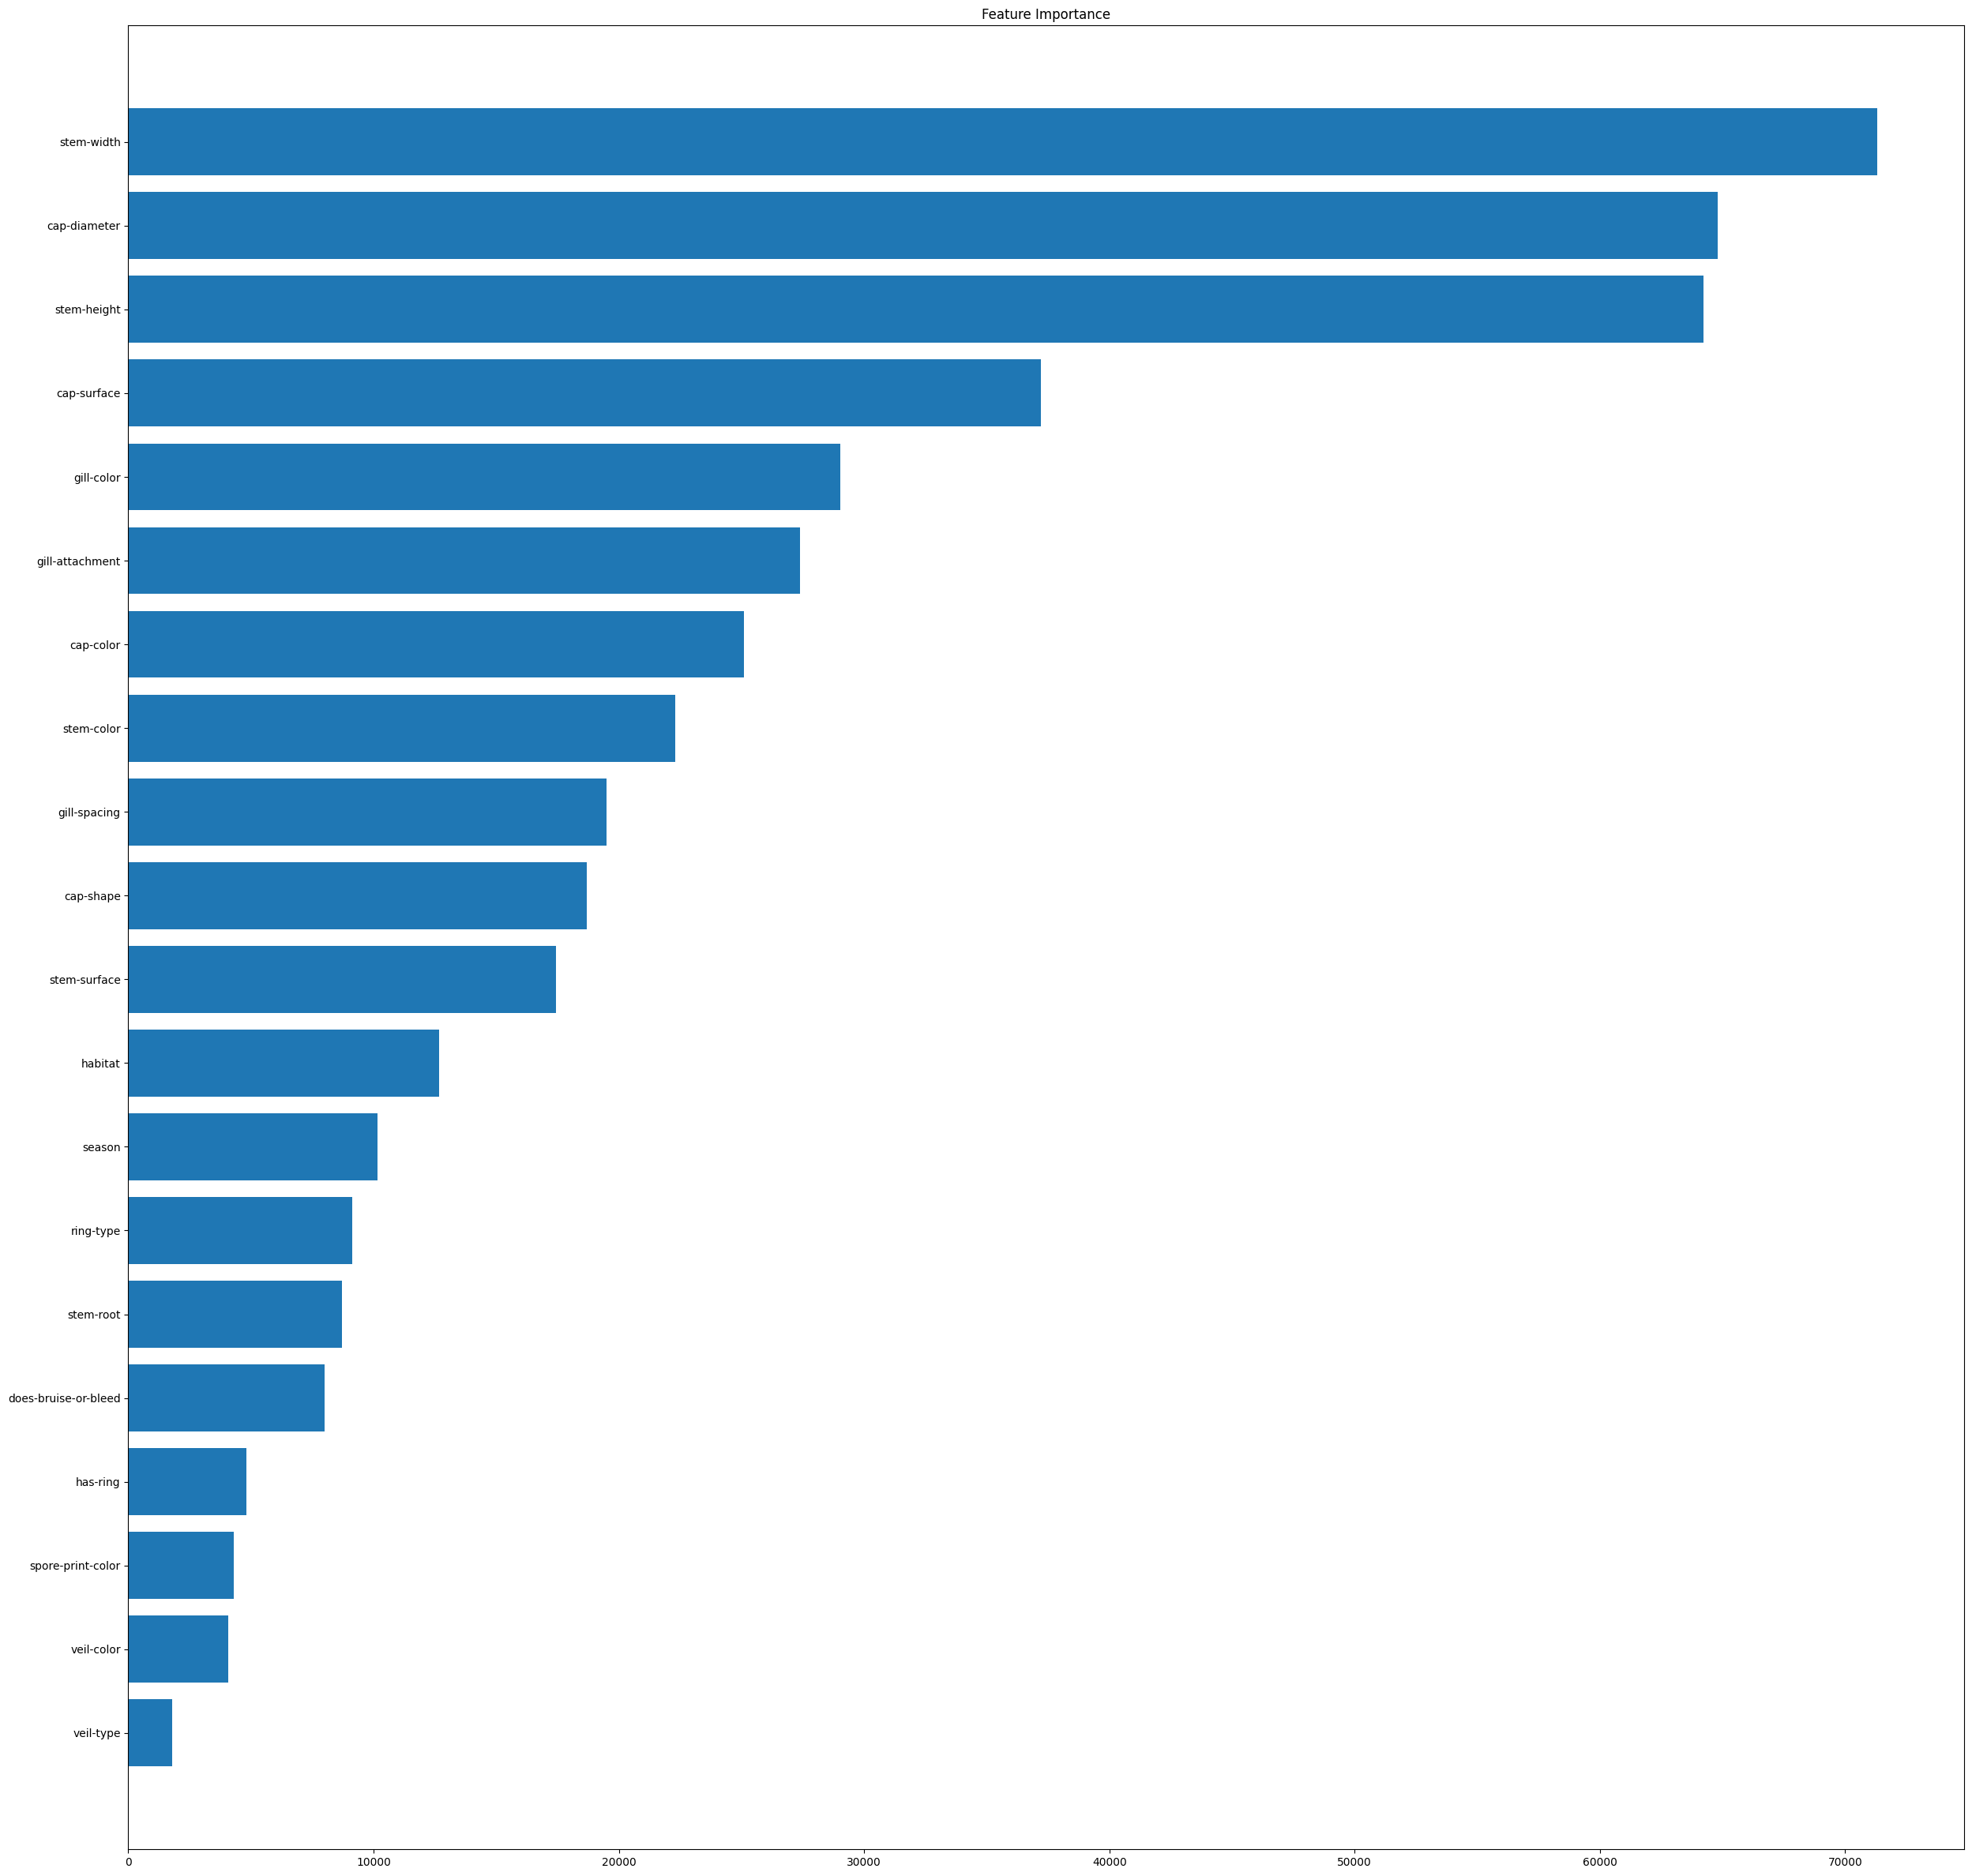

In [33]:
imps = model.feature_importance()
sorted_idx = np.argsort(imps)
plt.figure(figsize=(30, 30))
plt.barh(range(len(sorted_idx)), imps[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), np.array(X_test.columns)[sorted_idx])
plt.title('Feature Importance')
plt.show()

# 7. Plotting model's predictions
It is always a good idea to plot probabilities as it can often give us an insight of how well our model works. In this case (binary classification) we can see that most of our probabilities are very close to 0 or 1 which means that the model is sure about its' predictions.

<Axes: ylabel='Count'>

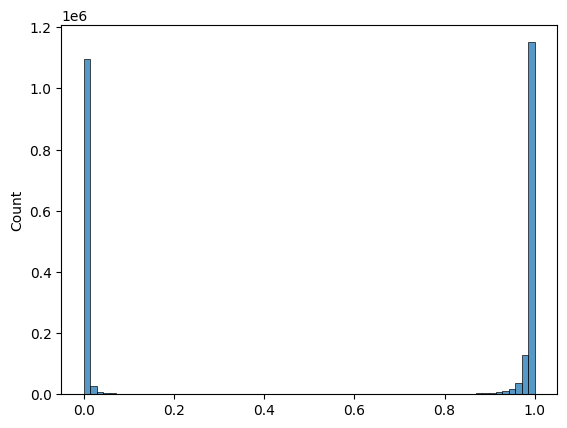

In [34]:
sns.histplot(model.predict(X_train))

<Axes: ylabel='Count'>

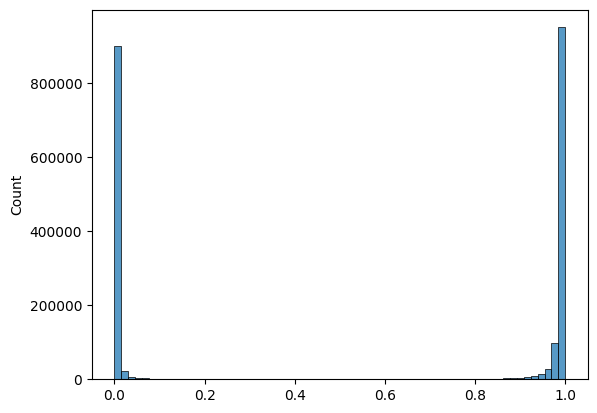

In [35]:
sns.histplot(model.predict(X_val))

<Axes: ylabel='Count'>

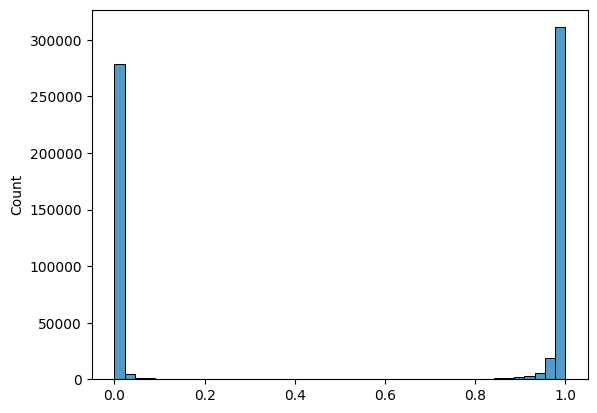

In [36]:
sns.histplot(model.predict(X_test))